# Exploratory Data Analysis

In [45]:
import json
import os
import datetime
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


data_path = Path("data/")

## Task 1

### Annotations

In [18]:
annotation_path = data_path / "task1" / "train" / "gold_task1.txt"
df = pd.read_csv(annotation_path)
annotation_users = df.Subject.values
df.head()

,Subject,Risk
0,user1036,1
1,user1037,1
2,user1150,1
3,user124,1
4,user1301,1


In [13]:
df.dtypes

Subject    object
Risk        int64
dtype: object

In [14]:
print("INFO:")
print(f"INFO: total number of users {len(df)}")
print(f"INFO: positive samples {df.Risk.sum()}")
print(f"INFO: negative samples {len(df) - df.Risk.sum()}")
df.describe()

INFO:
INFO: total number of users 350
INFO: positive samples 172
INFO: negative samples 178


,Risk
count,350.000000
mean,0.491429
std,0.500642
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Messages

In [25]:
user_messages_path = data_path / "task1" / "train" / "subjects"
user_messages = list(user_messages_path.glob("*.json"))
print(f"INFO: number of users with found messages {len(user_messages)}")

messages_users = [s.name.replace(".json", "") for s in user_messages]
print(f"INFO: inconsistency between messages users and annotation users: {set(annotation_users) - set(messages_users)}")


INFO: number of users with found messages 350
INFO: inconsistency between messages users and annotation users: set()


In [ ]:
with open(user_messages[0], "r") as file:
    messages = json.load(file)


messages_df = pd.DataFrame(messages)
messages_df["date"] = pd.to_datetime(messages_df["date"])
messages_df.set_index("date", inplace=True)
messages_df.head()

,id_message,message,platform
date,,,
2021-04-27 22:30:20+01:00,60951539963,El canal del amigo se llama loco por el trading ?,Telegram
2021-04-28 00:12:59+01:00,16299019771,Hay vivo hoy ?,Telegram
2021-04-29 01:11:42+01:00,34554847765,Eos alguien lo vio ?,Telegram
2021-04-29 02:15:10+01:00,84775152095,A que hora es el vivo ?,Telegram
2021-04-30 03:13:18+01:00,22627629888,No arranca vet,Telegram


In [70]:
all_messages = []
for user_file in user_messages:
    with open(user_file, "r") as file:
        messages = json.load(file)
    
    messages_df = pd.DataFrame(messages)
    messages_df["date"] = pd.to_datetime(messages_df["date"], format="%Y-%m-%d %H:%M:%S%z")
    messages_df["user"] = user_file.name.replace(".json", "")
    all_messages.append(messages_df)

all_messages_df = pd.concat(all_messages, ignore_index=True)
all_messages_df.set_index("date", inplace=True)
print(f"INFO: full dataset shape {df.shape}")

if "platform" in df.columns:
    unique_platforms = df["platform"].dropna().unique()
    print("INFO: Unique Platforms:", unique_platforms)
else:
    print("No 'platform' column found in dataset.")

nan_summary = df.isnull().sum()

print("INFO: Missing Values:")
print(nan_summary)

INFO: full dataset shape (22491, 3)
INFO: Unique Platforms: ['Telegram' 'Twitch']
INFO: Missing Values:
id_message    0
message       1
platform      0
dtype: int64


In [71]:
all_messages_df.tail()

,id_message,message,platform,user
date,,,,
2022-10-08 01:33:29+01:00,82720946231,"Buenas , Hoy hay directo ?",Telegram,user9984
2022-10-08 01:52:36+01:00,79539893868,😈,Telegram,user9984
2022-10-08 02:16:18+01:00,44449300457,Sip,Telegram,user9984
2022-10-08 05:57:06+01:00,45268249237,Jaja si es verdad user 7376 la misma con $ 125...,Telegram,user9984
2022-11-02 19:55:16+01:00,10802100092,Y en cuánto tiempo se estabiliza el mercado ?,Telegram,user9984


INFO: total number of messages 22491
INFO: number of messages per platform platform
Telegram    19573
Twitch       2918
Name: count, dtype: int64


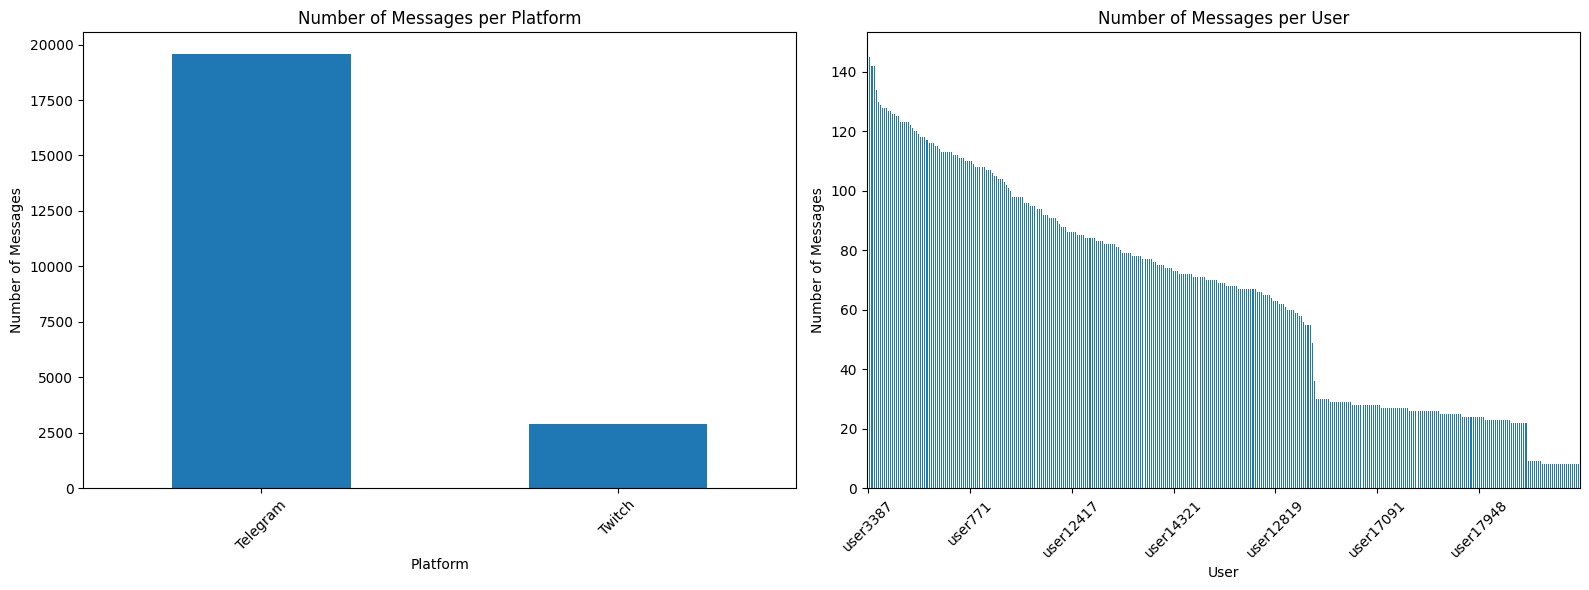

In [84]:
total_messages = len(all_messages_df)
print(f"INFO: total number of messages {total_messages}")
platform_counts = all_messages_df['platform'].value_counts()
print(f"INFO: number of messages per platform {platform_counts}")
user_counts = all_messages_df['user'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

platform_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Number of Messages per Platform')
axes[0].set_xlabel('Platform')
axes[0].set_ylabel('Number of Messages')
axes[0].tick_params(axis='x', rotation=45)

user_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title('Number of Messages per User')
axes[1].set_xlabel('User')
axes[1].set_ylabel('Number of Messages')
axes[1].tick_params(axis='x', rotation=45) 

N = 50
axes[1].set_xticks(axes[1].get_xticks()[::N])
plt.tight_layout()
plt.show()

1. clear unbalance towards Telegram platform messages
1. Three observed categories of users:
    - messages $<20$
    - $20<$ messages $<60$
    - messages $<60$

TODO:
- positives and negatives per platform
- positives and negatives per number of messages